## Setup

In [1]:
# Facial image emotion recognition using CNN
# Target classes: Angry, Disgusted, Fearful, Happy, Sad, Surprised, Neutral

import tensorflow as tf

NUM_THREADS = 32

tf.config.threading.set_intra_op_parallelism_threads(NUM_THREADS)
tf.config.threading.set_inter_op_parallelism_threads(NUM_THREADS)

# Switch to GPU
physical_devices = tf.config.experimental.list_physical_devices("GPU")
print("Num GPUs Available: ", len(physical_devices))
print(physical_devices)
for dev in physical_devices:
    tf.config.experimental.set_memory_growth(dev, True)


# DATASET
# files in dataset/test and dataset/train
# subfolders: angry, disgusted, fearful, happy, sad, surprised, neutral

# load dataset
train_dir = "dataset/train"
test_dir = "dataset/test"

2024-07-11 10:05:37.847253: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-11 10:05:37.870384: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-11 10:05:37.870418: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-11 10:05:37.886408: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-11 10:05:38.617800: W tensorflow/com

Num GPUs Available:  2
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


In [2]:
# Test data
# Check for the number of images in each class and the size of the images
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "0"  # 0 = alle Meldungen werden ausgegeben

# List of classes
classes = sorted(["angry", "disgust", "fear", "happy", "sad", "surprise", "neutral"])

# Number of images in each class
print("Number of training images in each class:")
for c in classes:
    path = os.path.join(train_dir, c)
    print(f"{c}: {len(os.listdir(path))} images")

print("\nNumber of test images in each class:")
for c in classes:
    path = os.path.join(test_dir, c)
    print(f"{c}: {len(os.listdir(path))} images")

# Image size
img = cv2.imread("dataset/train/angry/Training_3908.jpg")
print(f"\nImage size: {img.shape}")

input_shape = img.shape

# Reduce image size to 48x48 pixels due to greyscale (original size: 48x48x3)
input_shape = (48, 48, 1)

Number of training images in each class:
angry: 4162 images
disgust: 411 images
fear: 4171 images
happy: 7628 images
sad: 5073 images
surprise: 2842 images
neutral: 5248 images

Number of test images in each class:
angry: 939 images
disgust: 84 images
fear: 982 images
happy: 1850 images
sad: 1270 images
surprise: 610 images
neutral: 1255 images

Image size: (48, 48, 3)


## Loading the images from disk

In [3]:
import dataloader

greyscale = True
augmentation = None

train_ds, test_ds = dataloader.load(
    train_dir, test_dir, 7, OneChannelOnly=greyscale, augmentations=augmentation
)

Found 29535 files belonging to 7 classes.


2024-07-11 10:05:42.084418: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 660 MB memory:  -> device: 0, name: Quadro RTX 6000, pci bus id: 0000:17:00.0, compute capability: 7.5
2024-07-11 10:05:42.084925: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 22769 MB memory:  -> device: 1, name: Quadro RTX 6000, pci bus id: 0000:65:00.0, compute capability: 7.5


Found 6990 files belonging to 7 classes.


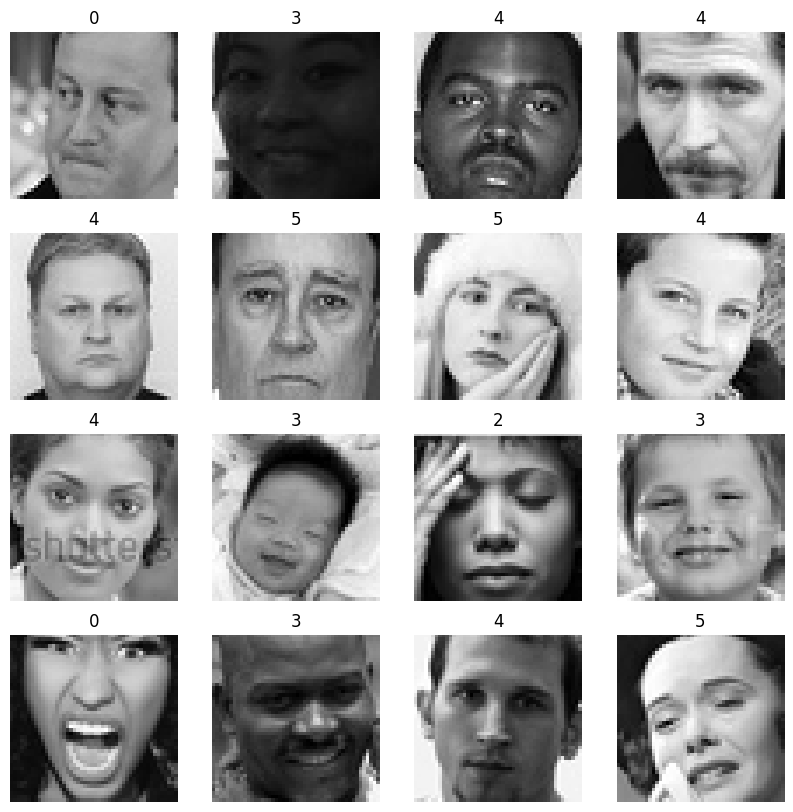

2024-07-11 10:05:44.389078: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [4]:
import matplotlib.pyplot as plt
import numpy as np

# Show the first 16 images and their labels
for images, labels in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    for i in range(16):
        ax = plt.subplot(4, 4, i + 1)
        if greyscale:
            plt.imshow(np.squeeze(images[i]), cmap="gray")
        else:
            plt.imshow(images[i])
        plt.title(np.argmax(labels[i]))
        plt.axis("off")
    plt.show()

Image shape: (64, 48, 48, 1), Label dtype: <dtype: 'float32'>
Image dtype: <dtype: 'float32'>, Label dtype: <dtype: 'float32'>


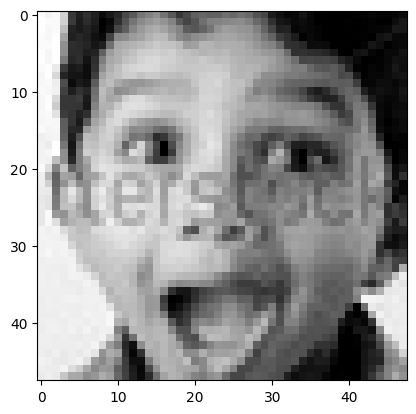

2024-07-11 10:05:44.485047: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [5]:
# Print one image (to confirm whether the images are represented as 48x48x1 tensors)
for img, label in train_ds.take(1):
    print(f"Image shape: {img.shape}, Label dtype: {label.dtype}")
    print(f"Image dtype: {img.dtype}, Label dtype: {label.dtype}")

    # Plot the image
    if greyscale:
        plt.imshow(np.squeeze(img[0]), cmap="gray")
    else:
        plt.imshow(img[0])
    plt.show()

## Class distribution and weights

2024-07-11 10:05:44.633231: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Train Class Distribution: Counter({3: 1850, 5: 1270, 4: 1255, 2: 982, 0: 939, 6: 610, 1: 84})
Test Class Distribution: Counter({3: 7628, 4: 5248, 5: 5073, 2: 4171, 0: 4162, 6: 2842, 1: 411})


2024-07-11 10:05:44.979913: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


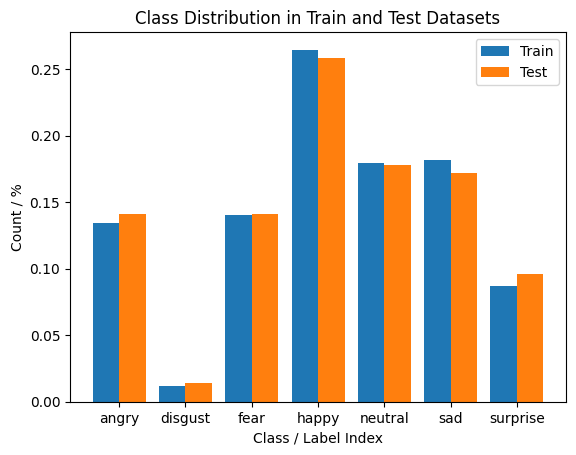

In [6]:
import collections


def get_class_distribution(dataset):
    class_counts = collections.Counter()

    for _, label_batch in dataset:
        labels = tf.argmax(label_batch, axis=1)
        class_counts.update(labels.numpy())

    return class_counts


# Klassenverteilung im Trainingsdatensatz
train_class_distribution = get_class_distribution(train_ds)
print("Train Class Distribution:", train_class_distribution)

# Klassenverteilung im Testdatensatz
test_class_distribution = get_class_distribution(test_ds)
print("Test Class Distribution:", test_class_distribution)


def plot_class_distributions(train_distribution, test_distribution, class_labels):
    classes = sorted(
        set(train_distribution.keys()).union(set(test_distribution.keys()))
    )

    train_counts = [train_distribution[cls] for cls in classes]
    test_counts = [test_distribution[cls] for cls in classes]

    width = 0.4  # width of the bars
    x = range(len(classes))  # the label locations

    fig, ax = plt.subplots()

    ax.bar(x, train_counts, width, label="Train", align="center")
    ax.bar([p + width for p in x], test_counts, width, label="Test", align="center")

    ax.set_xlabel("Class / Label Index")
    ax.set_ylabel("Count / %")
    ax.set_title("Class Distribution in Train and Test Datasets")
    ax.set_xticks([p + width / 2 for p in x])
    ax.set_xticklabels([class_labels[cls] for cls in classes])
    ax.legend()

    plt.show()


class_labels = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

train_total = sum(train_class_distribution.values())
test_total = sum(test_class_distribution.values())

train_class_distribution = {
    k: v / train_total for k, v in train_class_distribution.items()
}
test_class_distribution = {
    k: v / test_total for k, v in test_class_distribution.items()
}

plot_class_distributions(train_class_distribution, test_class_distribution, class_labels)

In [7]:
import sklearn
from sklearn.utils import class_weight

# Load labels as vector
y_train = []
for i, c in enumerate(classes):
    path = os.path.join(train_dir, c)
    for img_name in os.listdir(path):
        if img is not None:  # Ensure the image was read correctly
            y_train.append(i)

In [8]:
y_train_encoded = tf.keras.utils.to_categorical(y_train, num_classes=7)

# Nehme an, y_train_labels sind die Labels deiner Trainingsdaten
y_train_labels = np.argmax(y_train_encoded, axis=1)
y_train_labels = y_train_labels.astype(np.int32)

# Berechnung der Klassengewichte
class_weights = class_weight.compute_class_weight(
    class_weight="balanced", classes=np.unique(y_train_labels), y=y_train_labels
)

# Convert the class weights to a dictionary. Use np.int32 as the key type
class_weights_dict = {
    int(k): float(v) for k, v in zip(np.unique(y_train_labels), class_weights)
}

print("Class weights:", class_weights_dict)
# Print the type of keys in the dictionary
print("Type of keys:", type(list(class_weights_dict.keys())[0]))
# Print the type of values in the dictionary
print("Type of values:", type(list(class_weights_dict.values())[0]))

Class weights: {0: 1.0137639870941169, 1: 10.265901981230448, 2: 1.0115765318354626, 3: 0.5531313206981796, 4: 0.8317141167525556, 5: 1.4846184779330451, 6: 0.8039797473867596}
Type of keys: <class 'int'>
Type of values: <class 'float'>


In [9]:
# Callback functions
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_accuracy", patience=50, restore_best_weights=True, mode="max"
)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_accuracy", factor=0.5, patience=20, min_lr=0.00001, mode="max"
)

## Preparing the model

In [10]:
import densenet
from tensorflow.keras import optimizers

input_shape = (48, 48, 1)
args = dict(
    input_shape = input_shape,
    num_blocks = 4,
    num_layers_per_block = [6, 12, 24, 16],  # DenseNet-121 configuration
    growth_rate = 32,
    reduction = 0.5,
    num_classes = 7,
    dropout_rate=0.3,      
    l2_regularization=1e-4,
)
model = densenet.DenseNet(**args)
model.build((None, *input_shape))
model.compile(
    optimizer=optimizers.Adam(),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)
model(tf.keras.Input(input_shape))
model.summary()

/data/hagemann/ml/venv/lib/python3.12/site-packages/keras/src/layers/layer.py:372: UserWarning: `build()` was called on layer 'dense_net', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


Model: "dense_net"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 24, 24, 64)     │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 24, 24, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_block_1 (DenseBlock)      │ ?                      │       338,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transition_layer_1              │ ?                      │       133,120 │
│ (TransitionLayer)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_block_2 (DenseBlock)      │ ?                      │     1,132,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transition_layer_2              │ ?                      │       824,320 │
│ (TransitionLayer)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_block_3 (DenseBlock)      │ ?                      │     4,090,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transition_layer_3              │ ?                      │     3,976,192 │
│ (TransitionLayer)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_block_4 (DenseBlock)      │ ?                      │     4,078,592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_117         │ (None, 1, 1, 3840)     │        15,360 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_117 (ReLU)                │ (None, 1, 1, 3840)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 3840)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 7)              │        26,887 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,619,335 (55.77 MB)

 Trainable params: 14,474,247 (55.21 MB)

 Non-trainable params: 145,088 (566.75 KB)

## Training & Evaluation

In [11]:
history = model.fit(
    train_ds,
    class_weight=class_weights_dict,
    epochs=10,
    validation_data=test_ds,
    callbacks=[reduce_lr, early_stopping],
)

Epoch 1/10


I0000 00:00:1720685182.544951   54317 service.cc:145] XLA service 0x7fc70c0365e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1720685182.545058   54317 service.cc:153]   StreamExecutor device (0): Quadro RTX 6000, Compute Capability 7.5
I0000 00:00:1720685182.545072   54317 service.cc:153]   StreamExecutor device (1): Quadro RTX 6000, Compute Capability 7.5
2024-07-11 10:06:23.877453: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-07-11 10:06:28.103720: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8902
2024-07-11 10:06:32.563932: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 565.92MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains i

ResourceExhaustedError: Graph execution error:

Detected at node StatefulPartitionedCall defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/data/hagemann/ml/venv/lib/python3.12/site-packages/ipykernel_launcher.py", line 18, in <module>

  File "/data/hagemann/ml/venv/lib/python3.12/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/data/hagemann/ml/venv/lib/python3.12/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/data/hagemann/ml/venv/lib/python3.12/site-packages/tornado/platform/asyncio.py", line 205, in start

  File "/home/hagemann/.local/lib/python3.12/asyncio/base_events.py", line 641, in run_forever

  File "/home/hagemann/.local/lib/python3.12/asyncio/base_events.py", line 1987, in _run_once

  File "/home/hagemann/.local/lib/python3.12/asyncio/events.py", line 88, in _run

  File "/data/hagemann/ml/venv/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue

  File "/data/hagemann/ml/venv/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 534, in process_one

  File "/data/hagemann/ml/venv/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell

  File "/data/hagemann/ml/venv/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 362, in execute_request

  File "/data/hagemann/ml/venv/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 778, in execute_request

  File "/data/hagemann/ml/venv/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 449, in do_execute

  File "/data/hagemann/ml/venv/lib/python3.12/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/data/hagemann/ml/venv/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3075, in run_cell

  File "/data/hagemann/ml/venv/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3130, in _run_cell

  File "/data/hagemann/ml/venv/lib/python3.12/site-packages/IPython/core/async_helpers.py", line 128, in _pseudo_sync_runner

  File "/data/hagemann/ml/venv/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3334, in run_cell_async

  File "/data/hagemann/ml/venv/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3517, in run_ast_nodes

  File "/data/hagemann/ml/venv/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3577, in run_code

  File "/tmp/hagemann/ipykernel_54136/443205291.py", line 1, in <module>

  File "/data/hagemann/ml/venv/lib/python3.12/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/data/hagemann/ml/venv/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 318, in fit

  File "/data/hagemann/ml/venv/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 121, in one_step_on_iterator

Out of memory while trying to allocate 3276800 bytes.
BufferAssignment OOM Debugging.
BufferAssignment stats:
             parameter allocation:  166.76MiB
              constant allocation:         4B
        maybe_live_out allocation:  165.65MiB
     preallocated temp allocation:  498.41MiB
  preallocated temp fragmentation:    8.13MiB (1.63%)
                 total allocation:  665.19MiB
              total fragmentation:    8.26MiB (1.24%)
Peak buffers:
	Buffer 1:
		Size: 128.00MiB
		Operator: op_type="Conv2D" op_name="dense_net_1/dense_block_4_1/layer_16_1/conv2d_115_1/convolution" source_file="/data/hagemann/ml/venv/lib/python3.12/site-packages/tensorflow/python/framework/ops.py" source_line=1177
		XLA Label: custom-call
		Shape: u8[134217728]
		==========================

	Buffer 2:
		Size: 18.00MiB
		Operator: op_type="ReluGrad" op_name="gradient_tape/dense_net_1/transition_layer_1_1/re_lu_118_1/ReluGrad"
		XLA Label: fusion
		Shape: f32[64,512,12,12]
		==========================

	Buffer 3:
		Size: 15.12MiB
		Operator: op_name="XLA_Args"
		XLA Label: fusion
		Shape: f32[1408,2816,1,1]
		==========================

	Buffer 4:
		Size: 15.12MiB
		Operator: op_name="XLA_Retvals"
		XLA Label: fusion
		Shape: f32[1,1,2816,1408]
		==========================

	Buffer 5:
		Size: 15.12MiB
		Operator: op_name="XLA_Retvals"
		XLA Label: fusion
		Shape: f32[1,1,2816,1408]
		==========================

	Buffer 6:
		Size: 15.12MiB
		Operator: op_name="XLA_Retvals"
		XLA Label: fusion
		Shape: f32[1,1,2816,1408]
		==========================

	Buffer 7:
		Size: 11.25MiB
		Operator: op_type="ReluGrad" op_name="gradient_tape/dense_net_1/transition_layer_2_1/re_lu_119_1/ReluGrad"
		XLA Label: fusion
		Shape: f32[64,1280,6,6]
		==========================

	Buffer 8:
		Size: 9.00MiB
		Operator: op_type="Conv2D" op_name="dense_net_1/conv2d_1/convolution" source_file="/data/hagemann/ml/venv/lib/python3.12/site-packages/tensorflow/python/framework/ops.py" source_line=1177
		XLA Label: custom-call
		Shape: f32[64,64,24,24]
		==========================

	Buffer 9:
		Size: 7.88MiB
		Operator: op_type="ReluGrad" op_name="gradient_tape/dense_net_1/dense_block_1_1/layer_6_1/re_lu_11_1/ReluGrad"
		XLA Label: fusion
		Shape: f32[64,224,12,12]
		==========================

	Buffer 10:
		Size: 6.75MiB
		Operator: op_type="ReluGrad" op_name="gradient_tape/dense_net_1/dense_block_1_1/layer_5_1/re_lu_9_1/ReluGrad"
		XLA Label: fusion
		Shape: f32[64,192,12,12]
		==========================

	Buffer 11:
		Size: 6.19MiB
		Operator: op_type="ReluGrad" op_name="gradient_tape/dense_net_1/transition_layer_3_1/re_lu_120_1/ReluGrad"
		XLA Label: fusion
		Shape: f32[64,2816,3,3]
		==========================

	Buffer 12:
		Size: 5.62MiB
		Operator: op_type="Relu" op_name="dense_net_1/dense_block_1_1/layer_4_1/re_lu_7_1/Relu"
		XLA Label: fusion
		Shape: f32[64,160,12,12]
		==========================

	Buffer 13:
		Size: 5.34MiB
		Operator: op_type="Relu" op_name="dense_net_1/dense_block_2_1/layer_12_1/re_lu_35_1/Relu"
		XLA Label: fusion
		Shape: f32[64,608,6,6]
		==========================

	Buffer 14:
		Size: 5.06MiB
		Operator: op_type="Relu" op_name="dense_net_1/dense_block_2_1/layer_11_1/re_lu_33_1/Relu"
		XLA Label: fusion
		Shape: f32[64,576,6,6]
		==========================

	Buffer 15:
		Size: 4.78MiB
		Operator: op_type="Relu" op_name="dense_net_1/dense_block_2_1/layer_10_1/re_lu_31_1/Relu"
		XLA Label: fusion
		Shape: f32[64,544,6,6]
		==========================


	 [[{{node StatefulPartitionedCall}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_one_step_on_iterator_80346]

In [ ]:
from util import plot_history

In [ ]:
plot_history(history)

In [ ]:
# Load test data
x_test = []
y_test = []

for i, c in enumerate(classes):
    path = os.path.join(test_dir, c)
    for img_name in os.listdir(path):
        img = cv2.imread(os.path.join(path, img_name))
        if img is not None:  # Ensure the image was read correctly
            if greyscale:
                img = cv2.resize(img, (48, 48))
                # Image to greyscale and shape (48, 48, 1)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                img = np.expand_dims(img, axis=-1)  # Add channel dimension for greyscale images
            else:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            # Normalize the image
            img = img / 255.0
            x_test.append(img)
            y_test.append(i)

x_test = np.array(x_test)
y_test = np.array(y_test)

# Bruh, why you taking so long..

y_test_encoded = tf.keras.utils.to_categorical(y_test, num_classes=7)

In [ ]:
# SAVE MODEL, if model is defined
if model is not None:
    model.save("emotion_recognition_model.h5")
    print("Model saved as emotion_recognition_model.h5")
else:
    # Load model
    model = tf.keras.models.load_model("emotion_recognition_model.h5")
    print("Model loaded from emotion_recognition_model.h5")

# Confusion matrix
from sklearn.metrics import confusion_matrix
import numpy as np
import seaborn as sns

# Evaluate model
evaluation = model.evaluate(x_test, y_test_encoded)

# print evaluation
print(evaluation)

# Predict test data
y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)

from sklearn.metrics import classification_report

print("Classification Report:\n", classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Normalize the confusion matrix
cm_normalized = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

print("Confusion Matrix:\n", cm)
print("Normalized Confusion Matrix:\n", cm_normalized)

# Display normalized confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(
    cm_normalized,
    annot=True,
    fmt=".2f",
    xticklabels=classes,
    yticklabels=classes,
    cmap="Blues",
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Normalized Confusion Matrix")
plt.show()

# 5x5 matrix with random pictures from the test set, labeled with the predicted emotion and the true emotion; text color is green if the prediction is correct, red otherwise
import random

plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    index = random.randint(0, len(x_test) - 1)
    img = x_test[index]
    img = np.reshape(img, [1, 48, 48, 1])
    prediction = model.predict(img)
    emotion = classes[np.argmax(prediction)]
    true_emotion = classes[y_test[index]]
    color = "g" if emotion == true_emotion else "r"
    # Image back to original size
    img = x_test[index]
    img = np.reshape(img, [48, 48])
    plt.imshow(img, cmap="gray")
    plt.title(f"Pred: {emotion}\nTrue: {true_emotion}", color=color)
    plt.axis("off")
    plt.tight_layout()

plt.show()

In [ ]:
evaluation[0]

# Hyperparam Optimization

In [ ]:
import numpy as np

def gaussian_peak(min_value, max_value, length, sharpness=0.01):
    offset = length // 2 + length // 5
    x = np.linspace(0, length - 1, length)
    peak_position = (max_value - min_value) / 2 + min_value
    peak = np.exp(-sharpness * ((x - offset) ** 2))
    scaled_peak = (peak - np.min(peak)) / (np.max(peak) - np.min(peak))
    scaled_peak = (max_value - min_value) * scaled_peak + min_value
    return np.round(scaled_peak).astype(int)

# Example usage:
min_value = 4
max_value = 32
length = 7

array_with_gaussian_peak = gaussian_peak(min_value, max_value, length)
print(array_with_gaussian_peak)

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import optuna
import densenet
from tensorflow.keras import optimizers
import tensorflow as tf
import numpy as np
from util import evaluate

input_shape = (48, 48, 1)

def objective(trial):
    # Suggest the number of dense blocks
    num_blocks = trial.suggest_int('num_blocks', 2, 10)
    
    # Suggest the max and min layers per block
    min_layers = trial.suggest_int('min_layers', 4, 8)
    max_layers = trial.suggest_int('max_layers', 16, 32)
    num_layers_per_block = gaussian_peak(min_layers, max_layers, num_blocks)
    print("XXX", num_layers_per_block)
    # Suggest other parameters
    growth_rate = trial.suggest_categorical('growth_rate', [16, 32, 48])
    reduction = trial.suggest_uniform('reduction', 0.4, 0.6)
    dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.4)
    l2_regularization = trial.suggest_loguniform('l2_regularization', 1e-6, 1e-3)
    
    # Define the model using the suggested parameters
    args = dict(
        input_shape=input_shape,
        num_blocks=num_blocks,
        num_layers_per_block=num_layers_per_block,
        growth_rate=growth_rate,
        reduction=reduction,
        num_classes=7,  # Assuming the number of classes is fixed
        dropout_rate=dropout_rate,
        l2_regularization=l2_regularization
    )
    
    model = densenet.DenseNet(**args)
    model.build((None, *input_shape))
    model.compile(
        optimizer=optimizers.Adam(),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )
    history = model.fit(
        train_ds,
        class_weight=class_weights_dict,
        epochs=20,
        validation_data=test_ds,
        callbacks=[reduce_lr, early_stopping],
    )
    plot_history(history)
    evaluate(model, x_test, y_test, y_test_encoded, classes)
    loss, accuracy = model.evaluate(x_test, y_test_encoded)
    return loss

In [ ]:
study = optuna.create_study(direction='minimize', study_name="custom-densenet", storage='sqlite:///optuna.db', load_if_exists=True)

In [ ]:
study.optimize(objective, n_trials=50)

In [ ]:
# Print the top 10 parameter sets
completed_trials = study.get_trials(deepcopy=False, states=[optuna.trial.TrialState.COMPLETE])

best_trials = sorted(completed_trials, key=lambda trial: trial.value)[:10]
for i, trial in enumerate(best_trials):
    print(f"Rank {i+1}: Loss = {trial.value}, Params = {trial.params}")